# Classifying MNIST with a simple model and quantum embeddings

Inspired by:  https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

Useful imports

In [1]:
# for the Boson Sampler
import perceval as pcvl
#import perceval.providers.scaleway as scw  # Uncomment to allow running on scaleway

# for the machine learning model
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from boson_sampler import BosonSampler
from utils import MNIST_partial, accuracy, plot_training_metrics
from model import MnistModel, evaluate

## Definition of the Boson Sampler

In [2]:
bs = BosonSampler(30, 2)
bs.embedding_size

435

## Dataset : a subset of MNIST dataset

In [3]:
# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(data='data', split = 'train')
val_dataset = MNIST_partial(data='data', split='val')

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

## Training loop

In [ ]:
# training loop
def fit(epochs, lr, model, train_loader, val_loader, bs: BosonSampler, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    # creation of empty lists to store the training metrics
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    for epoch in range(epochs):
        training_losses, training_accs = 0, 0
        ## Training Phase
        for step, batch in enumerate(tqdm(train_loader)):
            # embedding in the BS
            if model.embedding_size:
                images, labs = batch
                images = images.squeeze(0).squeeze(0)
                t_s = time.time()
                embs = bs.embed(images,1000)
                loss,acc = model.training_step(batch,emb = embs.unsqueeze(0))

            else:
                loss,acc = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            training_losses+=int(loss.detach())
            training_accs+=int(acc.detach())
            if model.embedding_size and step%100==0:
                print(f"STEP {step}, Training-acc = {training_accs/(step+1)}, Training-losses = {training_losses/(step+1)}")
        
        ## Validation phase
        result = evaluate(model, val_loader, bs)
        validation_loss, validation_acc = result['val_loss'], result['val_acc']
        model.epoch_end(epoch, result)
        history.append(result)

        ## summing up all the training and validation metrics
        training_loss = training_losses/len(train_loader)
        training_accs = training_accs/len(train_loader)
        train_loss.append(training_loss)
        train_acc.append(training_accs)
        val_loss.append(validation_loss)
        val_acc.append(validation_acc)

        # plot training curves
        # plot_training_metrics(train_acc,val_acc,train_loss,val_loss)
    return(history)


## Model training

In [5]:
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

In [10]:
# definition of the BosonSampler
# here, we use 30 photons and 2 modes

bs = BosonSampler(30, 2, postselect = 2, session = session)
print(f"Boson sampler defined with number of parameters = {bs.nb_parameters}, and embedding size = {bs.embedding_size}")

#to display it
# pcvl.pdisplay(bs.create_circuit())

Boson sampler defined with number of parameters = 855, and embedding size = 435


In [ ]:
# define device to run the model
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = "mps"
print(f'DEVICE = {device}')

DEVICE = mps


In [8]:
# define the model and send it to the appropriate device
# set embedding_size = bs.embedding_size if you want to use the boson sampler in input of the model
model = MnistModel(device = device)
#model = MnistModel(device = device, embedding_size = bs.embedding_size)
model = model.to(device)

100%|██████████| 6000/6000 [00:22<00:00, 264.61it/s]


Epoch [0], val_loss: 0.7778, val_acc: 0.8317


100%|██████████| 6000/6000 [00:19<00:00, 309.79it/s]


Epoch [1], val_loss: 0.5903, val_acc: 0.8500


100%|██████████| 6000/6000 [00:19<00:00, 313.13it/s]


Epoch [2], val_loss: 0.5154, val_acc: 0.8550


100%|██████████| 6000/6000 [00:19<00:00, 308.41it/s]


Epoch [3], val_loss: 0.4763, val_acc: 0.8633


100%|██████████| 6000/6000 [00:19<00:00, 312.23it/s]


Epoch [4], val_loss: 0.4455, val_acc: 0.8733


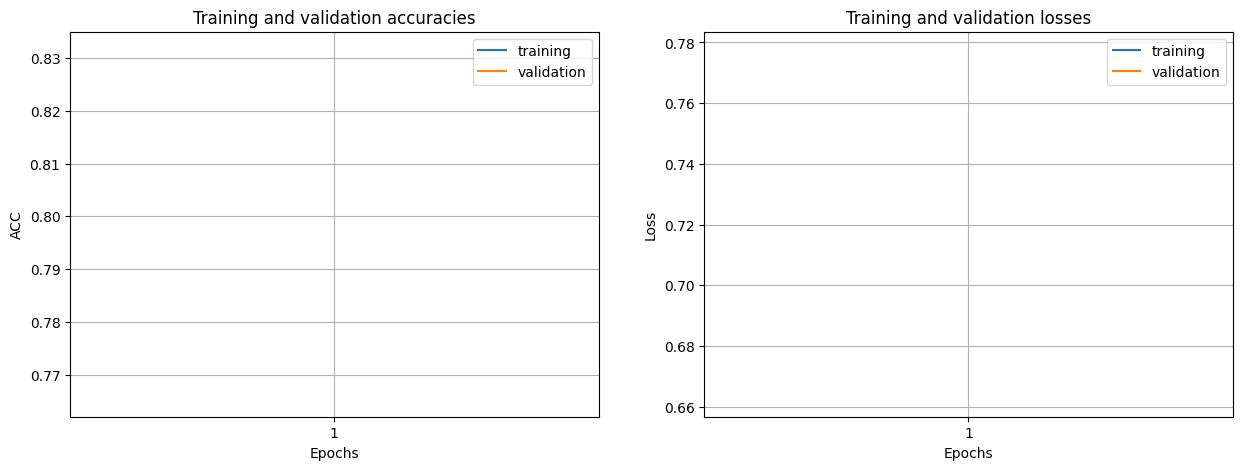

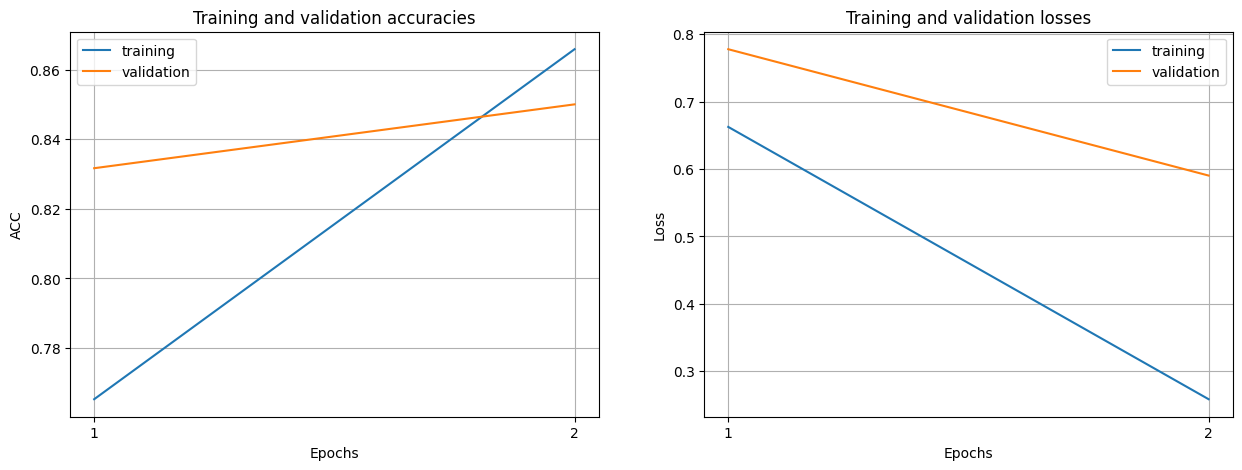

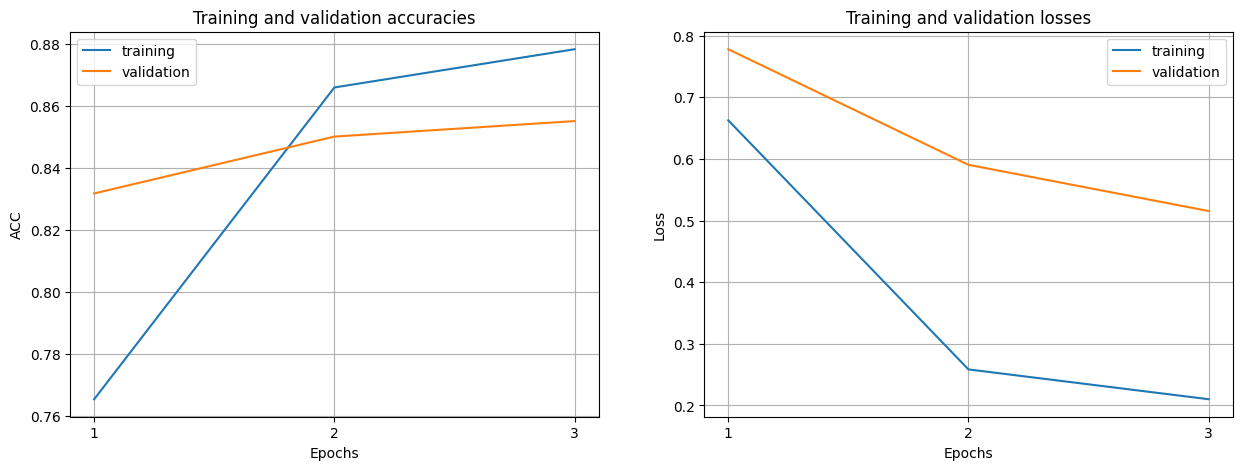

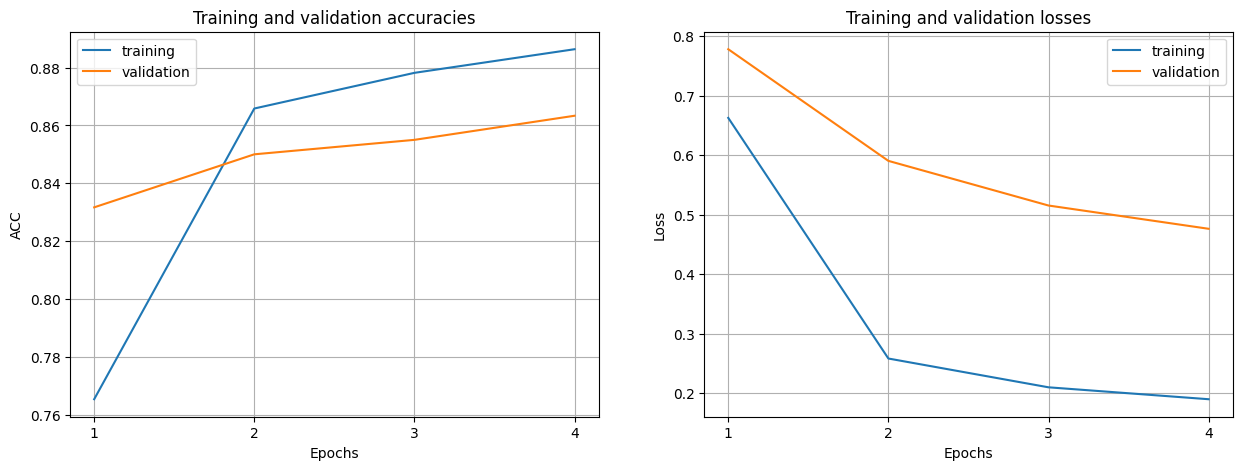

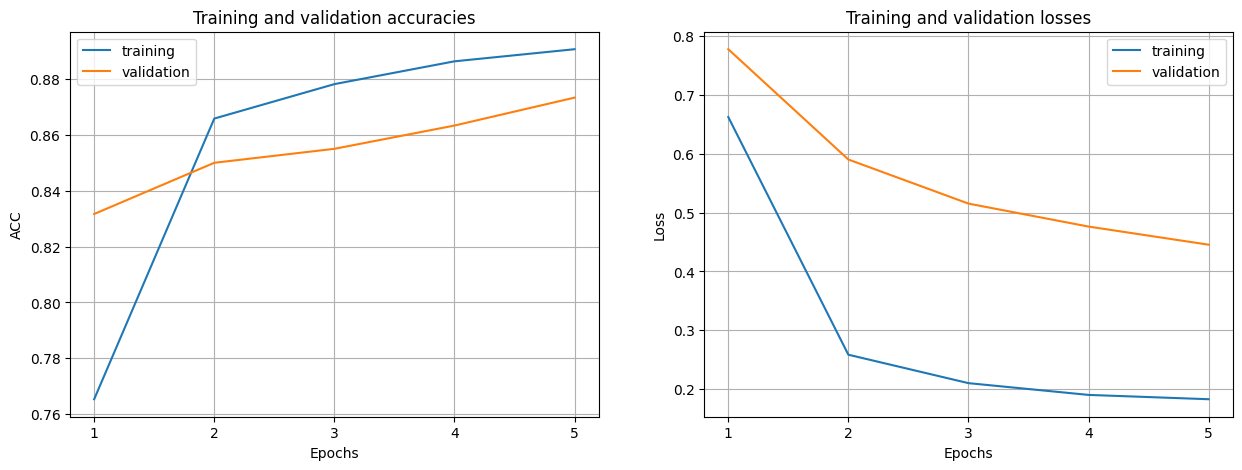

In [9]:
# train the model with the chosen parameters
experiment = fit(epochs = 5, lr = 0.001, model = model, train_loader = train_loader, val_loader = val_loader, bs=bs)

In [ ]:
# end session if needed
if session is not None:
    session.stop()